In [25]:
#%pip install seaborn

In [ ]:
# %%capture
# # Descomenta y ejecuta esta celda si necesitas instalar las librerías
# !pip install pandas numpy matplotlib seaborn torch darts optuna pyarrow scikit-learn statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import torch
import optuna

# Importaciones de Darts
from darts import TimeSeries
from darts.models import RNNModel#, LSTMModel, GRUModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mse

# Otras librerías útiles
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
import warnings

# --- Configuraciones ---
# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configuración de Matplotlib para gráficos más atractivos
plt.style.use('seaborn-v0_8')  # Using a valid seaborn style
plt.rcParams['figure.figsize'] = (16, 8)

# Configuración para reproducibilidad de PyTorch
torch.manual_seed(42)
np.random.seed(42)

print("Librerías importadas y entorno configurado exitosamente.")

Librerías importadas y entorno configurado exitosamente.


In [27]:
# --- Carga de Datos ---
# Cargar los datos de entrenamiento y prueba desde los archivos Parquet.
# Asegúrate de que las rutas a los archivos sean correctas.
try:
    df_train = pd.read_parquet('../../Datos/df_train.parquet')
    df_test = pd.read_parquet('../../Datos/df_test.parquet')
except FileNotFoundError:
    print("Archivos de datos no encontrados. Creando DataFrames de ejemplo.")
    # Creación de datos de ejemplo si los archivos no existen
    # Esto permite que el notebook se ejecute de forma autónoma para demostración.
    date_rng_train = pd.date_range(start='2015-01-01', end='2021-12-31', freq='W-Sun')
    date_rng_test = pd.date_range(start='2022-01-01', end='2022-12-31', freq='W-Sun')
    barrios = ['Barrio_A', 'Barrio_B', 'Barrio_C', 'Barrio_D']
    
    df_train_list = []
    for barrio in barrios:
        data = {
            'fecha': date_rng_train,
            'barrio': barrio,
            'casos_dengue': np.abs(np.random.randint(5, 50, size=len(date_rng_train)) + np.sin(np.arange(len(date_rng_train)) / 52 * 2 * np.pi) * 20),
            'temperatura_media': np.random.uniform(20, 30, size=len(date_rng_train)),
            'precipitacion': np.random.uniform(0, 15, size=len(date_rng_train)),
        }
        df_train_list.append(pd.DataFrame(data))
    df_train = pd.concat(df_train_list)

    df_test_list = []
    for barrio in barrios:
        data = {
            'fecha': date_rng_test,
            'barrio': barrio,
            'temperatura_media': np.random.uniform(20, 30, size=len(date_rng_test)),
            'precipitacion': np.random.uniform(0, 15, size=len(date_rng_test)),
        }
        df_test_list.append(pd.DataFrame(data))
    df_test = pd.concat(df_test_list)


# --- Preparación Inicial ---
# Crear columna de fecha a partir de año y semana
df_train['fecha'] = pd.to_datetime(df_train['anio'].astype(str) + '-W' + df_train['semana'].astype(str) + '-1', format='%Y-W%U-%w')
df_test['fecha'] = pd.to_datetime(df_test['anio'].astype(str) + '-W' + df_test['semana'].astype(str) + '-1', format='%Y-W%U-%w')

# Establecer 'fecha' como el índice del DataFrame
df_train.set_index('fecha', inplace=True)
df_test.set_index('fecha', inplace=True)

# Ordenar el índice para asegurar la secuencia temporal correcta
df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)


# --- Verificación de la Carga ---
print("--- Datos de Entrenamiento ---")
print(df_train.head())
print("\n")
df_train.info()

print("\n\n--- Datos de Prueba ---")
print(df_test.head())
print("\n")
df_test.info()

--- Datos de Entrenamiento ---
                   id  id_bar  anio  semana  ESTRATO  area_barrio  dengue  \
fecha                                                                       
2015-01-05  4_2015_01       4  2015       1      3.0        0.560     0.0   
2015-01-05  5_2015_01       5  2015       1      3.0        0.842     0.0   
2015-01-05  3_2015_01       3  2015       1      1.0        0.781     0.0   
2015-01-05  8_2015_01       8  2015       1      2.0        0.394     0.0   
2015-01-05  9_2015_01       9  2015       1      2.0        0.292     0.0   

            concentraciones  vivienda  equipesado  sumideros  maquina  \
fecha                                                                   
2015-01-05              0.0       0.0         0.0        0.0      0.0   
2015-01-05              0.0       0.0         0.0        0.0      0.0   
2015-01-05              0.0       0.0         0.0        0.0      0.0   
2015-01-05              0.0       0.0         0.0        0.0    

In [28]:
df_train

,id,id_bar,anio,semana,ESTRATO,area_barrio,dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min
fecha,,,,,,,,,,,,,,,,,,,,
2015-01-05,4_2015_01,4,2015,1,3.0,0.560,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,5_2015_01,5,2015,1,3.0,0.842,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,3_2015_01,3,2015,1,1.0,0.781,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,8_2015_01,8,2015,1,2.0,0.394,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,9_2015_01,9,2015,1,2.0,0.292,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03,2_2021_53,2,2021,53,2.0,0.780,0.0,0.0,0.0,0.0,0.0,0.0,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364
2022-01-03,6_2021_53,6,2021,53,1.0,0.381,1.0,0.0,0.0,0.0,0.0,0.0,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364
2022-01-03,1_2021_53,1,2021,53,1.0,0.600,1.0,0.0,0.0,0.0,0.0,0.0,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364


In [29]:
df_train.rename(columns={'id_bar': 'barrio'}, inplace=True)
df_test.rename(columns={'id_bar': 'barrio'}, inplace=True)
df_train.rename(columns={'dengue': 'casos_dengue'}, inplace=True)
df_test.rename(columns={'dengue': 'casos_dengue'}, inplace=True)

In [30]:
df_train

,id,barrio,anio,semana,ESTRATO,area_barrio,casos_dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min
fecha,,,,,,,,,,,,,,,,,,,,
2015-01-05,4_2015_01,4,2015,1,3.0,0.560,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,5_2015_01,5,2015,1,3.0,0.842,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,3_2015_01,3,2015,1,1.0,0.781,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,8_2015_01,8,2015,1,2.0,0.394,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
2015-01-05,9_2015_01,9,2015,1,2.0,0.292,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.062500,0.0,26.163889,11.588928,31.800000,20.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-03,2_2021_53,2,2021,53,2.0,0.780,0.0,0.0,0.0,0.0,0.0,0.0,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364
2022-01-03,6_2021_53,6,2021,53,1.0,0.381,1.0,0.0,0.0,0.0,0.0,0.0,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364
2022-01-03,1_2021_53,1,2021,53,1.0,0.600,1.0,0.0,0.0,0.0,0.0,0.0,0.277575,2.310524,10.090138,0.0,25.824778,11.174080,32.994039,20.705364


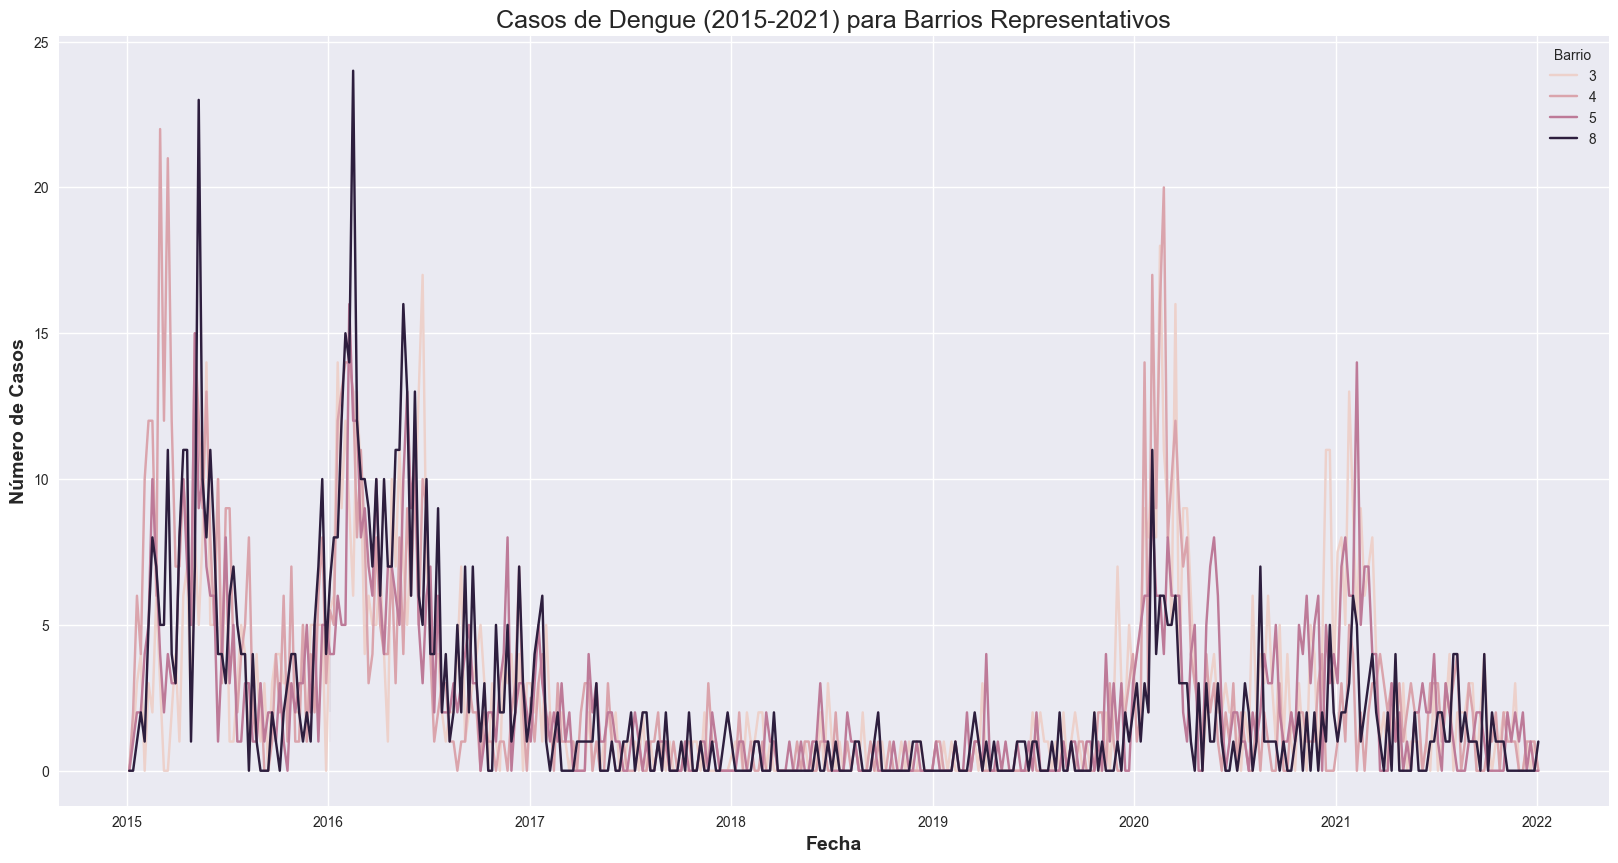

In [31]:
# Seleccionamos una muestra de barrios para visualizar
barrios_representativos = df_train['barrio'].unique()[:4]

# Graficamos la serie temporal de casos de dengue
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_train[df_train['barrio'].isin(barrios_representativos)], 
             x='fecha', y='casos_dengue', hue='barrio')
plt.title('Casos de Dengue (2015-2021) para Barrios Representativos', fontsize=18)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Número de Casos', fontsize=14)
plt.legend(title='Barrio')
plt.show()  

In [32]:
# Realizamos la descomposición estacional para los mismos barrios
# Usamos un modelo aditivo y un período de 52 (semanas en un año)
for barrio in barrios_representativos:
    print(f"--- Descomposición para el {barrio} ---")
    
    # Filtramos los datos para el barrio actual
    # Filtramos los datos para el barrio actual y aseguramos que el índice sea único
    serie_barrio = df_train[df_train['barrio'] == barrio]['casos_dengue']
    serie_barrio = serie_barrio[~serie_barrio.index.duplicated(keep='first')].asfreq('W-SUN')
    
    # Rellenamos los valores faltantes usando interpolación
    serie_barrio = serie_barrio.interpolate(method='time')
    
    # Eliminamos cualquier valor restante que sea NaN después de la interpolación
    serie_barrio = serie_barrio.dropna()
    
    # Verificamos si la serie tiene suficientes datos para la descomposición
    if len(serie_barrio) >= 104:  # Al menos 2 ciclos completos (52 semanas por ciclo)
        # Realizamos la descomposición
        decomposition = seasonal_decompose(serie_barrio, model='additive', period=52)
        
        # Graficamos los componentes
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
        decomposition.observed.plot(ax=ax1)
        ax1.set_ylabel('Observado')
        decomposition.trend.plot(ax=ax2)
        ax2.set_ylabel('Tendencia')
        decomposition.seasonal.plot(ax=ax3)
        ax3.set_ylabel('Estacionalidad')
        decomposition.resid.plot(ax=ax4)
        ax4.set_ylabel('Residuos')
        plt.suptitle(f'Descomposición de la Serie Temporal - {barrio}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
    else:
        print(f"La serie para el barrio {barrio} no tiene suficientes datos para la descomposición (observaciones: {len(serie_barrio)}).")

--- Descomposición para el 4 ---
La serie para el barrio 4 no tiene suficientes datos para la descomposición (observaciones: 0).
--- Descomposición para el 5 ---
La serie para el barrio 5 no tiene suficientes datos para la descomposición (observaciones: 0).
--- Descomposición para el 3 ---
La serie para el barrio 3 no tiene suficientes datos para la descomposición (observaciones: 0).
--- Descomposición para el 8 ---
La serie para el barrio 8 no tiene suficientes datos para la descomposición (observaciones: 0).


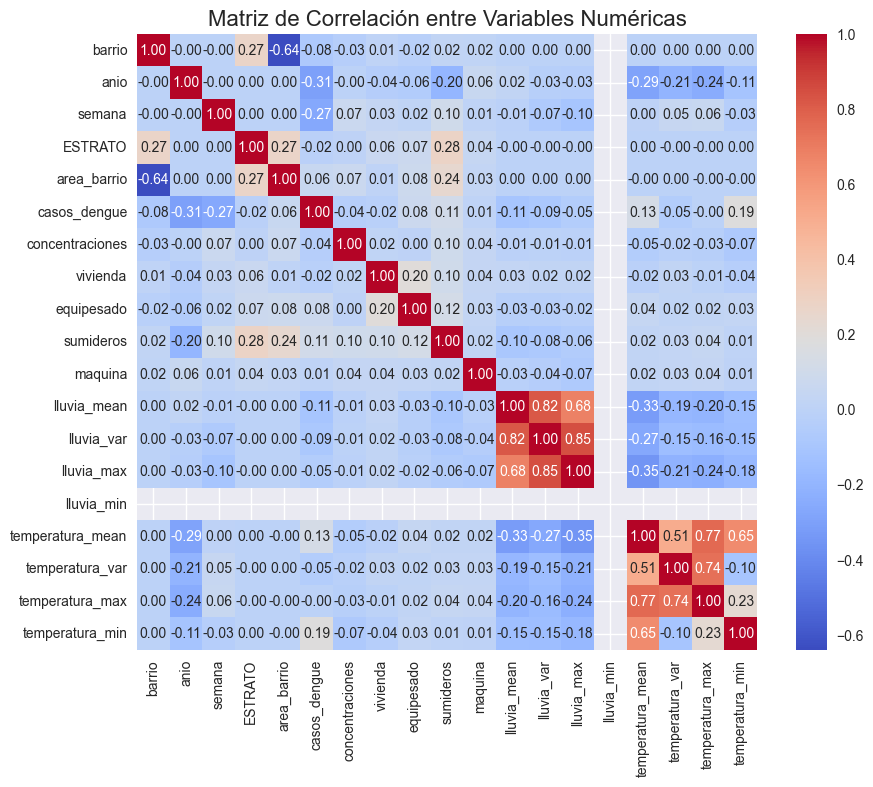

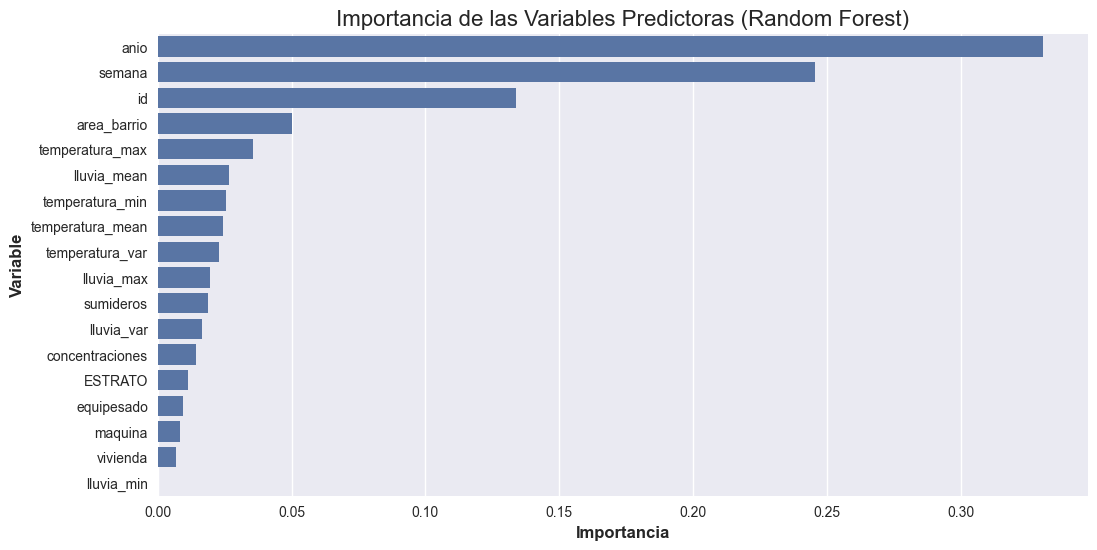

In [33]:
# 1. Matriz de Correlación
# Seleccionamos solo las columnas numéricas para el análisis de correlación
numeric_cols = df_train.select_dtypes(include=np.number).columns
correlation_matrix = df_train[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre Variables Numéricas', fontsize=16)
plt.show()

# 2. Importancia de Variables con RandomForest
# Preparamos los datos para el modelo
# Excluimos 'barrio' ya que es categórica y el modelo se entrena por separado
X = df_train.drop(columns=['casos_dengue', 'barrio'])
y = df_train['casos_dengue']

# Instanciamos y entrenamos el modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Creamos un DataFrame con la importancia de las características
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizamos la importancia
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Importancia de las Variables Predictoras (Random Forest)', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.show()

In [39]:
# --- Creación de TimeSeries de Darts ---

# Identificamos las columnas objetivo y las covariables
target_col = 'casos_dengue'
# Ensure 'id' exists in the DataFrame before including it in covariate_cols
covariate_cols = [col for col in df_train.columns if col not in [target_col, 'barrio']]

# Convertimos los DataFrames de pandas en una lista de TimeSeries, una para cada barrio.

# 1. Series de entrenamiento (objetivo y covariables pasadas)
series_train = []
past_covariates_train = []

for barrio in df_train['barrio'].unique():
    df_barrio = df_train[df_train['barrio'] == barrio]
    # Ensure 'fecha' is reset as a column in df_barrio
    if 'fecha' not in df_barrio.columns:
        df_barrio = df_barrio.reset_index()

    # Ensure unique 'fecha' values by grouping and aggregating
    # Exclude non-numeric columns before applying mean()
    numeric_cols = df_barrio.select_dtypes(include=[np.number]).columns
    df_barrio_grouped = df_barrio.groupby('fecha')[numeric_cols].mean().reset_index()

    # Ensure the DataFrame is reindexed to include all timestamps for the specified frequency
    full_date_range = pd.date_range(start=df_barrio_grouped['fecha'].min(), 
                                    end=df_barrio_grouped['fecha'].max(), 
                                    freq='W-SUN')
    df_barrio_grouped = df_barrio_grouped.set_index('fecha').reindex(full_date_range).reset_index()
    df_barrio_grouped.rename(columns={'index': 'fecha'}, inplace=True)

    series_train.append(
        TimeSeries.from_dataframe(
            df_barrio_grouped, time_col='fecha', value_cols=target_col, freq='W-SUN', fill_missing_dates=True, fillna_value=0
        )
    )
    past_covariates_train.append(
        TimeSeries.from_dataframe(
            df_barrio_grouped, time_col='fecha', value_cols=covariate_cols, freq='W-SUN', fill_missing_dates=True, fillna_value=0
        )
    )

# 2. Covariables futuras (datos exógenos del período de prueba)
future_covariates_test = []

for barrio in df_test['barrio'].unique():
    df_barrio = df_test[df_test['barrio'] == barrio]
    future_covariates_test.append(
        TimeSeries.from_dataframe(
            df_barrio, time_col='fecha', value_cols=covariate_cols, freq='W-SUN', fill_missing_dates=True, fillna_value=0
        )
    )

print(f"Se crearon {len(series_train)} series de entrenamiento (una por barrio).")
print(f"Dimensiones de la primera serie objetivo: {series_train[0].pd_dataframe().shape}")
print(f"Dimensiones de las covariables pasadas: {past_covariates_train[0].pd_dataframe().shape}")
print(f"Dimensiones de las covariables futuras: {future_covariates_test[0].pd_dataframe().shape}")


# --- Escalado de Datos ---
# Usamos MinMaxScaler para escalar los datos en el rango [0, 1].
# Esto es crucial para el buen rendimiento de las redes neuronales.

# Escalador para la variable objetivo
scaler_target = Scaler()
series_train_scaled = scaler_target.fit_transform(series_train)

# Escalador para las covariables
# Es importante usar un escalador diferente para las covariables.
scaler_covariates = Scaler()
past_covariates_train_scaled = scaler_covariates.fit_transform(past_covariates_train)
future_covariates_test_scaled = scaler_covariates.transform(future_covariates_test) # Solo transformar, no ajustar

print("\nDatos escalados exitosamente.")
print(f"Valor mínimo y máximo de la primera serie objetivo escalada: {series_train_scaled[0].min().item():.2f}, {series_train_scaled[0].max().item():.2f}")

KeyError: "['id'] not in index"